In [1]:
#import packages
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanMCMC

/opt/anaconda3/envs/stan_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#modify import path
import sys
sys.path.append('../our_analysis')

#import our code
from logreg import run_logistic_regression

In [3]:
#Set WD
notebook_dir = os.getcwd()

In [ ]:
#load dataset
df = pd.read_csv("../dataset/beh_noslow.csv") # need to change this later

story_trials = df[df["condition"] == "story"]
abstract_trials=df[df["condition"] == "abstract"]

## need to do some data cleaning as they have nans

below we are plotting only the raw probabilities. I need to modify this to plot the logit based predicted probabilities. Also need to double check how the transition stay/leave is calculated

In [ ]:
story_fit = run_logistic_regression(
    df=story_df,
    condition_name='story',
    iter_sampling=32000, 
    warmup=16000,  
    chains=4  
)

# For abstract condition
abstract_fit = run_logistic_regression(
    df=abstract_df,
    condition_name='abstract',
    output_dir='my_results',
    iter_sampling=32000, 
    warmup=16000,  
    chains=4  
)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-6487.150000,0.233080,24.391500,23.158200,-6524.680000,-6488.460000,-6444.910000,11992.1,12885.0,1.00043
"coefs[1,1]",1.113130,0.001191,0.427295,0.403611,0.478845,1.077970,1.867340,145717.0,76095.7,1.00018
"coefs[1,2]",-0.094735,0.000953,0.267334,0.234373,-0.570100,-0.065899,0.284694,85847.0,72313.1,1.00004
"coefs[1,3]",0.815087,0.000828,0.298918,0.282334,0.365262,0.795535,1.332240,137636.0,84081.6,1.00006
"coefs[1,4]",2.646060,0.001475,0.484001,0.456922,1.949520,2.594010,3.524440,127148.0,76232.5,1.00009
...,...,...,...,...,...,...,...,...,...,...
"Sigma[3,4]",0.105941,0.000096,0.030971,0.029468,0.060769,0.102961,0.161531,103625.0,103091.0,1.00001
"Sigma[4,1]",0.142996,0.000164,0.057579,0.055070,0.056338,0.138699,0.244221,130676.0,83486.2,1.00001
"Sigma[4,2]",0.000240,0.000077,0.019651,0.018495,-0.032496,0.000562,0.031687,65608.8,87413.5,1.00003
"Sigma[4,3]",0.105941,0.000096,0.030971,0.029468,0.060769,0.102961,0.161531,103625.0,103091.0,1.00001


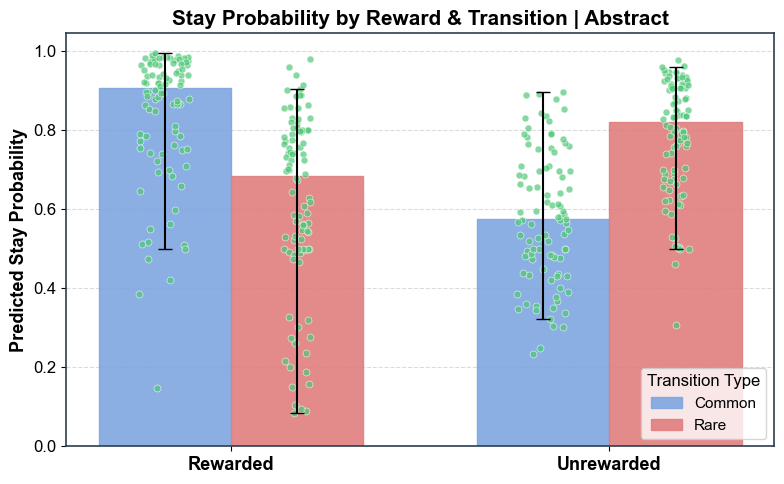

In [38]:
posterior = fit.draws_pd()

n_participants = 94  #need to double check number of pts. Also need to decide whether or not to model with slow/noslow
## i think i need to reduce the n to restrict to only model the abstract condition pts.

#four possible combinations
conds = {
    "Rewarded-Common":   ( 1,  1),
    "Rewarded-Rare":     ( 1, -1),
    "Unrewarded-Common": (-1,  1),
    "Unrewarded-Rare":   (-1, -1),
}

#use fits to compute the logit for each possible condition
participant_meds = {name: [] for name in conds}
for pid in range(1, n_participants + 1):
    b0  = posterior[f"coefs[{pid},1]"]
    br  = posterior[f"coefs[{pid},2]"]
    bt  = posterior[f"coefs[{pid},3]"]
    bir = posterior[f"coefs[{pid},4]"]
    for name, (xr, xt) in conds.items():
        lin = b0 + br*xr + bt*xt + bir*(xr*xt)
        ps  = 1 / (1 + np.exp(-lin))      # logistic
        participant_meds[name].append(np.median(ps))

#Split groups
groups      = ["Rewarded", "Unrewarded"]
common_vals = [participant_meds[f"{g}-Common"] for g in groups]
rare_vals   = [participant_meds[f"{g}-Rare"]   for g in groups]

#compute group stats
common_meds = [np.median(vals) for vals in common_vals]
rare_meds   = [np.median(vals) for vals in rare_vals]
common_hdis = [az.hdi(np.array(vals), hdi_prob=0.95) for vals in common_vals]
rare_hdis   = [az.hdi(np.array(vals), hdi_prob=0.95) for vals in rare_vals]

#plotting
x     = np.arange(len(groups))
width = 0.35

plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})
fig, ax = plt.subplots(figsize=(8,5), facecolor='white')

#common
ax.bar(
    x - width/2,
    common_meds,
    width,
    yerr=np.array([
        [m - lo for m, (lo, hi) in zip(common_meds, common_hdis)],
        [hi - m for m, (lo, hi) in zip(common_meds, common_hdis)]
    ]),
    capsize=5,
    color="#7EA6E0",     
    edgecolor="#7EA6E0", 
    label="Common",
    alpha=0.9,
)
#rare
ax.bar(
    x + width/2,
    rare_meds,
    width,
    yerr=np.array([
        [m - lo for m, (lo, hi) in zip(rare_meds, rare_hdis)],
        [hi - m for m, (lo, hi) in zip(rare_meds, rare_hdis)]
    ]),
    capsize=5,
    color="#E07E7E",     
    edgecolor="#E07E7E",
    label="Rare",
    alpha=0.9,
)

dot_color = "#50C878"  
for i, g in enumerate(groups):
    # Common dots
    jitter = (np.random.rand(n_participants) - 0.5) * width * 0.4
    ax.scatter(
        np.full(n_participants, x[i] - width/2) + jitter,
        common_vals[i],
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )
    # Rare dots
    jitter = (np.random.rand(n_participants) - 0.5) * width * 0.2
    ax.scatter(
        np.full(n_participants, x[i] + width/2) + jitter,
        rare_vals[i],
        color=dot_color,
        alpha=0.7,
        s=25,
        edgecolor='white',
        linewidth=0.5
    )
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=13, fontweight='bold')
ax.set_ylabel("Predicted Stay Probability", fontsize=13, fontweight='bold')
ax.set_title("Stay Probability by Reward & Transition | Abstract", fontsize=15, fontweight='bold')
ax.legend(title="Transition Type", fontsize=11, title_fontsize=12)

ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('#2C3E50')

plt.tight_layout()
plt.show()